# Imports

In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import random
import networkx as nx
import math
import numpy as np
import itertools
sys.path.append('..')
from pprint import pprint
from matplotlib import cm, pyplot
from IPython.core.debugger import set_trace
from heapq import nlargest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append(module_path)

In [59]:
from MaaSSim.utils import *  # simulator
from MaaSSim.shared import prep_shared_rides
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.animations import *

# Parameters

In [60]:
params = get_config('daan.json')
params.nP = 10 # Passengers default = 100
params.nV = 10 # Vehicles default = 50
params.nD = 20 # Run days
params.potential.dist_cost = .3 # Driving cost per km in EUR (.17 in literature)
params.potential.time_cost = 15 / 3600 # Cost per second in EUR (Value of time)
params.potential.available = 20 # Seconds the request potential is available after request time
params.simTime = 1 # Simulation time in hours
params.repos_wait_time = 10
params.city = 'Delft, Netherlands'

In [61]:
def_params = get_config('../../data/config/delft.json')  # load configuration
params.paths = def_params.paths

# Functions

In [62]:
def veh_kpi_daan(*args,**kwargs):
    sim =  kwargs.get('sim', None)
    run_id = kwargs.get('run_id', None)
    simrun = sim.runs[run_id]
    vehindex = sim.inData.vehicles.index
    
    df = simrun['rides'].copy()  # results of previous simulation
    DECIDES_NOT_TO_DRIVE = df[df.event == driverEvent.DECIDES_NOT_TO_DRIVE.name].veh  # track drivers out
    dfs = df.shift(-1)  # to map time periods between events
    dfs.columns = [_ + "_s" for _ in df.columns]  # columns with _s are shifted
    df = pd.concat([df, dfs], axis=1)  # now we have time periods
    df = df[df.veh == df.veh_s]  # filter for the same vehicles only
    df = df[~(df.t == df.t_s)]  # filter for positive time periods only
    df['dt'] = df.t_s - df.t  # make time intervals
    ret = df.groupby(['veh', 'event_s'])['dt'].sum().unstack()  # aggreagted by vehicle and event
    #del ret.columns.name
    ret = ret.reindex(vehindex)  # update for vehicles with no record
    ret['nRIDES'] = df[df.event == driverEvent.ARRIVES_AT_DROPOFF.name].groupby(
        ['veh']).size().reindex(ret.index)
    ret['nREJECTED'] = df[df.event == driverEvent.IS_REJECTED_BY_TRAVELLER.name].groupby(
        ['veh']).size().reindex(ret.index)
    for status in driverEvent:
        if status.name not in ret.columns:
            ret[status.name] = 0  # cover all statuss
    DECIDES_NOT_TO_DRIVE.index = DECIDES_NOT_TO_DRIVE.values
    ret['OUT'] = DECIDES_NOT_TO_DRIVE
    ret['OUT'] = ~ret['OUT'].isnull()
    ret = ret[['nRIDES', 'nREJECTED', 'OUT'] + [_.name for _ in driverEvent]].fillna(0)  # nans become 0
    ret.index.name = 'veh'
    
    ret['DRIVING_TIME'] = ret['REPOSITIONED'] + ret['ARRIVES_AT_PICKUP'] + ret['ARRIVES_AT_DROPOFF']
    ret['DRIVING_DIST'] = ret['DRIVING_TIME'] * (params.speeds.ride / 1000)

    ret['REVENUE'] = (ret['ARRIVES_AT_DROPOFF'] * (params.speeds.ride / 1000) * params.fares.km + params.fares.base * ret['nRIDES']) * (1 - params.fares.commission)
    ret['COST'] = ret['DRIVING_DIST'] * params.potential.dist_cost
    ret['PROFIT'] = ret['REVENUE'] - ret['COST']
    
    # KPIs
    kpi = ret.agg(['sum', 'mean', 'std'])
    kpi['nV'] = ret.shape[0]
    return {'veh_exp': ret, 'veh_kpi': kpi}

In [63]:
# def veh_kpi_daan(*args,**kwargs):
#     simrun = kwargs.get('simrun',None)
#     vehindex = kwargs.get('vehindex',None)
#     simvehs = kwargs.get('simvehs', None) # Dict of vehicle objects
#     # Structuring the output data like this assumes that each of the start_travel events ALWAYS..
#     # ..has their corresponding end_travel event in simrun.rides dataframe
#     start_travel = [driverEvent.STARTS_REPOSITIONING.name, driverEvent.IS_ACCEPTED_BY_TRAVELLER.name, driverEvent.DEPARTS_FROM_PICKUP.name]
#     end_travel = [driverEvent.REPOSITIONED.name, driverEvent.ARRIVES_AT_PICKUP.name, driverEvent.ARRIVES_AT_DROPOFF.name] 
#     df = simrun['rides'].loc[[ev in start_travel for ev in simrun['rides']['event']]].reset_index() # Get rows for events when driver starts driving
#     df2 = simrun['rides'].loc[[ev in end_travel for ev in simrun['rides']['event']]].reset_index() # Get rows for events when driver stops driving
#     df2.columns = [_+"_arr" for _ in df2.columns] # Add _arr to arrival columns
#     df = pd.concat([df,df2], axis=1) # Start and stop information of each driving trip are now in same row
#     df['t_diff'] = df['t_arr'] - df['t'] # Calculate time for each driving trip and add to new col
#     df.loc[df['t_diff'] < 0, 't_diff'] = 0 # Set negative values to zero (happens when driver is accepted after arriving at pickup)
#     #set_trace()
#     ret = df.groupby(['veh','event'])['t_diff'].sum().unstack()
#     del ret.columns.name
#     for status in start_travel:
#         if status not in ret.columns:
#             ret[status] = 0

#     ret = ret.reindex(vehindex) ##### See it this is correct
#     ret = ret.rename(columns = {'STARTS_REPOSITIONING': 'REPOS_TIME','IS_ACCEPTED_BY_TRAVELLER':'MATCH_TIME','DEPARTS_FROM_PICKUP': 'RIDE_TIME'})
#     #set_trace()
#     ret['IDLE_DURING_REPOS_TIME'] = pd.Series({ind: v.wait_at_max for ind, v in simvehs.items()})
#     ret['REPOS_TIME'] = ret['REPOS_TIME'] - ret['IDLE_DURING_REPOS_TIME']
#     ret['nRIDES'] = df[df.event_arr == driverEvent.ARRIVES_AT_DROPOFF.name].groupby(['veh']).size().reindex(ret.index)

#     ret = ret.fillna(0)

#     ret['RIDE_DIST'] = ret['RIDE_TIME'] * (params.speeds.ride / 1000)
#     ret['MATCH_DIST'] = ret['MATCH_TIME'] * (params.speeds.ride / 1000)
#     ret['REPOS_DIST'] = ret['REPOS_TIME'] * (params.speeds.ride / 1000)

#     ret['DRIVING_TIME'] = ret['REPOS_TIME'] + ret['MATCH_TIME'] + ret['RIDE_TIME']
#     ret['DRIVING_DIST'] = ret['DRIVING_TIME'] * (params.speeds.ride / 1000)

#     ret['REVENUE'] = (ret['RIDE_DIST'] * params.fares.km + params.fares.base * ret['nRIDES']) * (1 - params.fares.commission)
#     ret['COST'] = ret['DRIVING_DIST'] * params.potential.dist_cost
#     ret['PROFIT'] = ret['REVENUE'] - ret['COST']
    
#     kpi = ret.agg(['sum', 'mean', 'std'])
#     kpi['nV'] = ret.shape[0]
#     return {'veh_exp': ret, 'veh_kpi': kpi}

In [64]:
def f_daan_repos(*args, **kwargs): # Input as repos function
    veh = kwargs.get('veh')
    data = veh.sim.inData
    nodes = data.G.nodes
    p_val_t = data.P.loc[veh.sim.env.now]
    cur_pos = veh.veh.pos
    new_pos = max([n for n in data.G.neighbors(cur_pos)], key = lambda x: p_val_t[x])
    repos = DotMap()
    #repos.path = []
    #repos.flag = True
    # repos.flag = False causes break out of reposition loop triggers driverEvent.REPOSITIONED
    if p_val_t[new_pos] > p_val_t[cur_pos]:
        repos.pos = new_pos # Reposition to node with highest exp_rev attribute value. Pick first encounter when similar values
        repos.time = veh.sim.skims.ride[cur_pos][new_pos] # Time from current to new node using time skim matrix
        #print(f"Vehicle {veh.id} at t:{veh.sim.env.now} from {cur_pos} (value: {round(p_val_t[cur_pos],2)}) to {new_pos} (value: {round(p_val_t[new_pos],2)})") 
        repos.wait = False
    else:
        repos.pos = cur_pos
        repos.time = params.repos_wait_time
        repos.wait = True
        #set_trace()
        #veh.wait_at_max += params.repos_wait_time
        #print(f"Vehicle {veh.id} waits at node {cur_pos} at time {veh.sim.env.now}")
    return repos

In [65]:
def reset_veh_pos(inData, fixed_supply):
    # Reset vehicles to their original starting position at start of a day
    inData.vehicles['pos'] = fixed_supply['pos']
    #print(fixed_supply['pos'], inData.vehicles['pos'])
    return

# Initialize

In [66]:
a = [list(i) for i in itertools.product([True,False],repeat=params.nV)]
use_repos_list = []
use_repos_list.extend([a[0],a[-1]])
use_repos_list.extend(random.sample(a[1:-1], k = params.nD - 2))

In [67]:
inData = load_G(inData, params, stats = True)
#inData = load_albatross_csv(inData, params) # params.nP randomly drawn requests from albatross
inData = generate_demand(inData, params, avg_speed = True)
fixed_supply = generate_vehicles(inData,params.nV)
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0] = empty_series(inData.platforms)
inData = prep_shared_rides(inData, params.shareability)
inData.vehicles = fixed_supply.copy()
inData.vehicles['wait_at_max'] = 0
inData.requests['revenue'] = inData.requests.apply(lambda request: (params.fares.base + request.dist / 1000 * params.fares.km) * (1 - params.fares.commission), axis = 1) # Calculate revenue and add revenue col to request list
inData.skim_decay = inData.skim.applymap(lambda x: -x / 1000 * params.potential.dist_cost)

# t0 and t1 are calculated here just like in the simulation object; t0 is minimum request time; t1 is simTime (in hours) times 3600
inData.requests['treq_sim'] = (inData.requests['treq'] - inData.requests.treq.min()).dt.total_seconds().astype(int) # Request time to simulation timesteps (seconds)
df_list = []
for i, req in inData.requests.iterrows():
    df = pd.DataFrame(index = range((params.simTime + 2) * 60 * 60 + 1), columns = inData.G.nodes, dtype = 'float').rename_axis(index = 'time', columns = 'nodes')  # Create df with nodes as columns and all timesteps as index
    df.loc[req['treq_sim']] = inData.skim_decay[req['origin']] + req['revenue']  # Create potential values of request with spatial decay and set it on the index of request time
    df.loc[0] = df.loc[req['treq_sim']] - req['treq_sim'] * params.potential.time_cost # Calculate the temporal decay at time t0 for each node and set row
    df.loc[0:req['treq_sim']] = df.loc[0:req['treq_sim']].interpolate() # Linear interpolation between t0 and t_req
    df.loc[req['treq_sim']:min(req['treq_sim'] + params.potential.available, len(df)),:] = df.loc[req['treq_sim']].values # Keep potential values the same for some time after t_req
    df_list.append(df)
p_vals = pd.concat(df_list, keys = range(len(inData.requests)), names = ['requests']) # Spatio-temporal potential values dataframe for each seperate request concatenated into one
p_vals = p_vals.groupby(by = 'time').max() # Find max value by comparing each node and time step for each request 
p_vals = p_vals.fillna(-10000)
inData.P = p_vals

In [68]:
sim = simulate(inData, params=params, f_driver_repos = f_daan_repos, kpi_veh = veh_kpi_daan)

18-11-20 14:02:56-WARNING-Setting up 1h simulation at 2020-11-18 13:34:30 for 10 vehicles and 10 passengers in Delft, Netherlands
18-11-20 14:02:56-INFO--------------------	Starting simulation	-------------------
18-11-20 14:02:58-INFO-pax    2  got to dest at                           2020-11-18 13:43:21
18-11-20 14:02:58-INFO-pax    0  got to dest at                           2020-11-18 13:43:42
18-11-20 14:02:58-INFO-pax    1  got to dest at                           2020-11-18 13:45:15
18-11-20 14:02:59-INFO-pax    4  got to dest at                           2020-11-18 14:14:53
18-11-20 14:02:59-INFO-pax    3  got to dest at                           2020-11-18 14:16:13
18-11-20 14:02:59-INFO-pax    6  got to dest at                           2020-11-18 14:18:54
18-11-20 14:02:59-INFO-pax    5  got to dest at                           2020-11-18 14:20:09
18-11-20 14:03:00-INFO-pax    9  got to dest at                           2020-11-18 14:32:34
18-11-20 14:03:00-INFO-pax    7  go

# Run

In [36]:
for day in range(params.nD):
    reset_veh_pos(inData, fixed_supply)
    inData.vehicles['use_repos'] = use_repos_list[day]
    sim.make_and_run(print = True)
    sim.output()

18-11-20 13:48:04-INFO--------------------	Starting simulation	-------------------
18-11-20 13:48:04-INFO-pax    1  got to dest at                           2020-11-18 13:29:34
18-11-20 13:48:04-INFO-pax    0  got to dest at                           2020-11-18 13:30:57
18-11-20 13:48:04-INFO-pax    2  got to dest at                           2020-11-18 13:43:38
18-11-20 13:48:04-INFO-pax    3  got to dest at                           2020-11-18 13:45:34
18-11-20 13:48:04-INFO-pax    4  got to dest at                           2020-11-18 13:49:40
18-11-20 13:48:04-INFO-pax    5  got to dest at                           2020-11-18 13:51:25
18-11-20 13:48:04-INFO-pax    6  got to dest at                           2020-11-18 13:52:33
18-11-20 13:48:04-INFO-pax    7  got to dest at                           2020-11-18 14:05:30
18-11-20 13:48:04-INFO-pax    8  got to dest at                           2020-11-18 14:08:14
18-11-20 13:48:04-INFO-pax    9  got to dest at                        

In [75]:
rides = sim.runs[2].rides
use_repos_list[2]
rides[rides.veh==2]

,veh,pos,t,event,paxes
0,2,4.477259e+07,0,STARTS_DAY,[]
1,2,4.477259e+07,0,OPENS_APP,[]
2,2,4.477259e+07,0,STARTS_REPOSITIONING,[]
3,2,4.477346e+07,2,REPOSITIONED,[]
4,2,4.477483e+07,5,REPOSITIONED,[]
...,...,...,...,...,...
72,2,1.421472e+09,2237,REPOSITIONED,[]
73,2,1.393025e+09,2237,REPOSITIONED,[]
74,2,4.476804e+07,2247,REPOSITIONED,[]
75,2,4.477259e+07,2264,REPOSITIONED,[]


In [37]:
# Manual change from repositioning to not repositioning
# inData.vehicles['use_repos'] = True # Set all vehicles repositioning strategy to repositioning
# sim.make_and_run(print = True)
# sim.output()
# reset_veh_pos(inData, fixed_supply) # Reset all vehicles to original position
# inData.vehicles['use_repos'] = False # Set all vehicles repositioning strategy to not repositioning
# sim.make_and_run(print = True)
# sim.output()

# Results

In [38]:
#print(sim.runs[0].rides.to_string())

In [39]:
print(f"Simulation in {params.city} with {params.nV} vehicles, {params.nP} passengers, simulation time of {params.simTime} hours")

Simulation in Delft, Netherlands with 10 vehicles, 10 passengers, simulation time of 1 hours


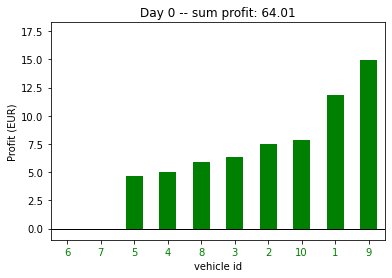

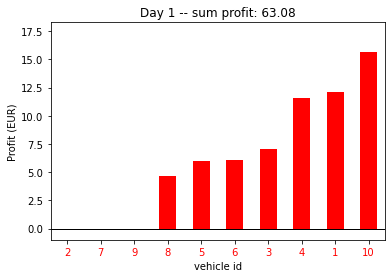

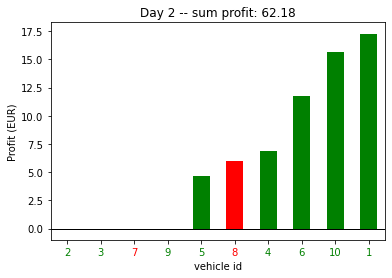

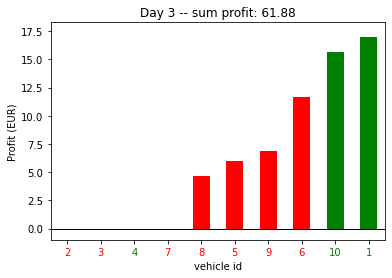

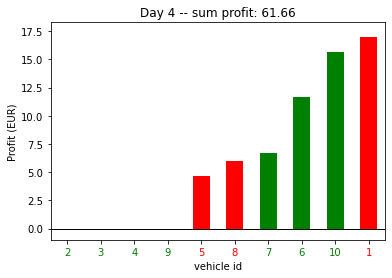

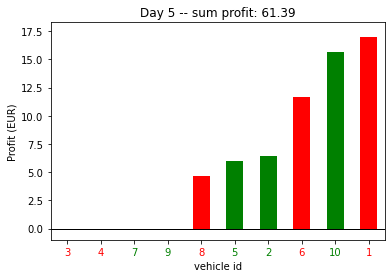

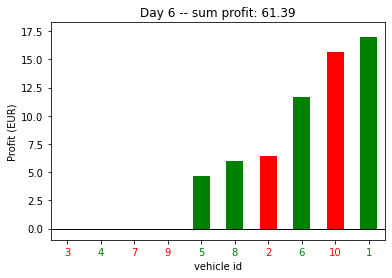

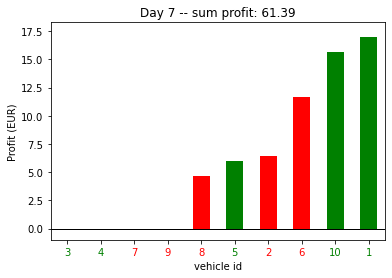

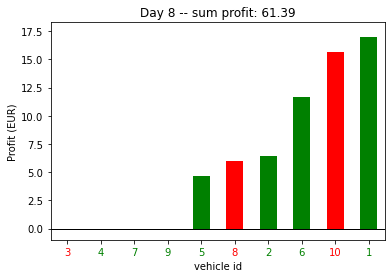

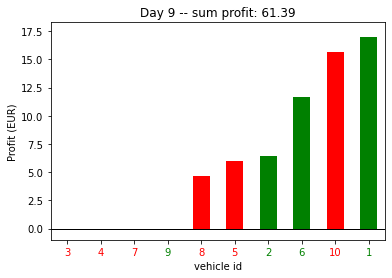

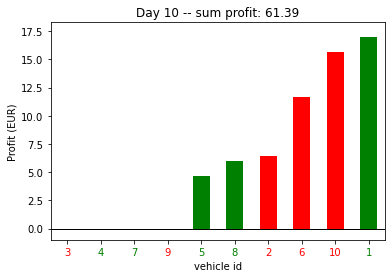

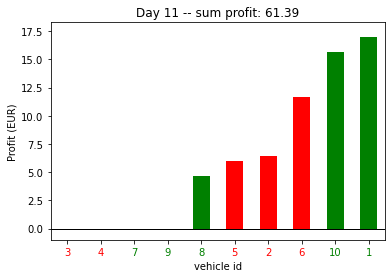

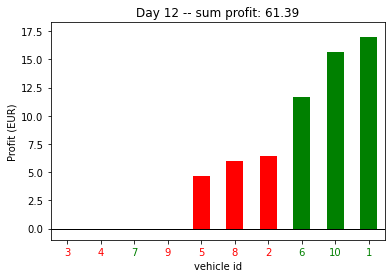

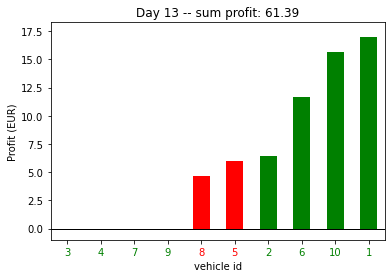

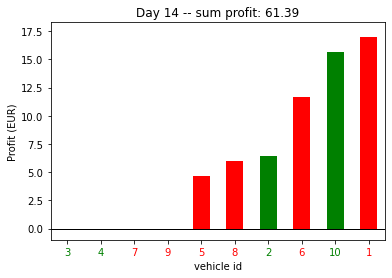

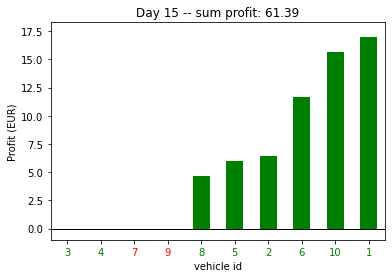

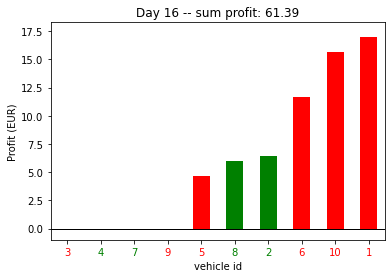

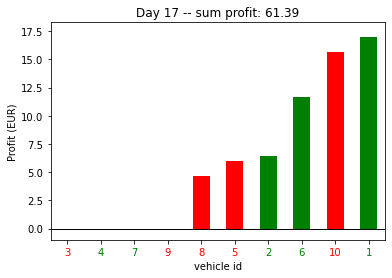

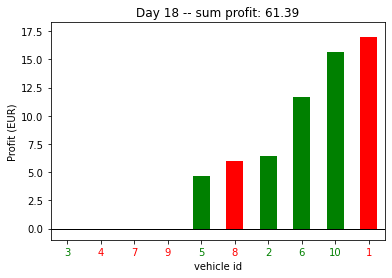

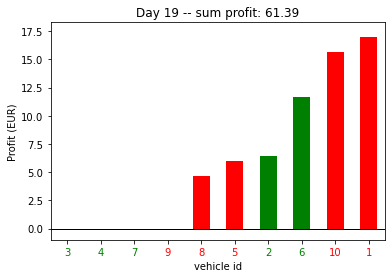

In [40]:
lst = []
for day in range(params.nD):
    lst.extend(sim.res[day].veh_exp['PROFIT'].to_list())
ymin = min(lst) - 1
ymax = max(lst) + 1

for day in range(params.nD):
    df = sim.res[day].veh_exp
    df['USE_REPOS'] = use_repos_list[day]
    df = df.sort_values(by=['PROFIT']) 
    colors = ['g' if i else 'r' for i in df['USE_REPOS']]
    
    s = df['PROFIT']
    sum_profit = round(sim.res[day].veh_kpi['PROFIT']['sum'],2)
    title_str = 'Day ' + str(day) + ' -- sum profit: ' + str(sum_profit)
    ax = s.plot.bar(rot=0, title = title_str, color = colors, ylim = (ymin,ymax)) 
    ax.set_ylabel('Profit (EUR)')
    ax.set_xlabel('vehicle id')
    ax.axhline(color='black',lw=1)
    [t.set_color(i) for (i,t) in zip(colors, ax.xaxis.get_ticklabels())]
    pyplot.show()

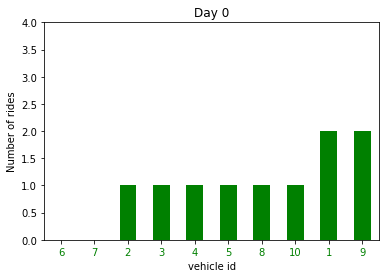

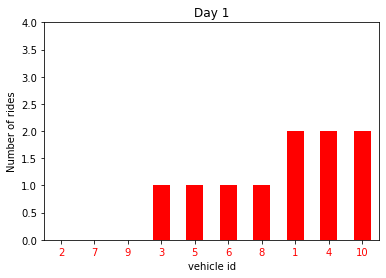

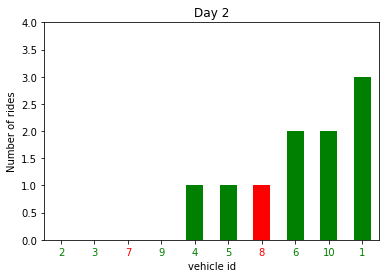

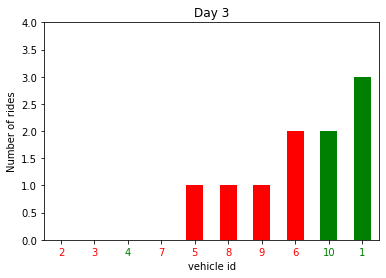

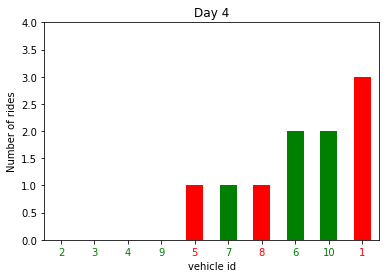

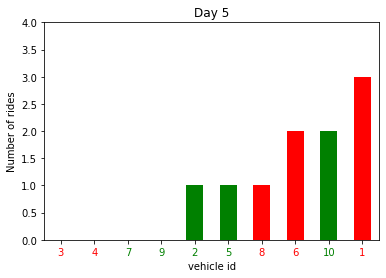

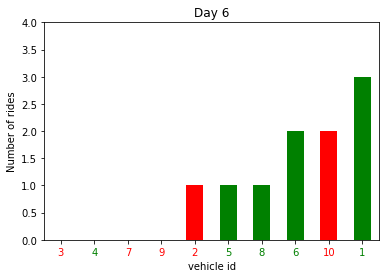

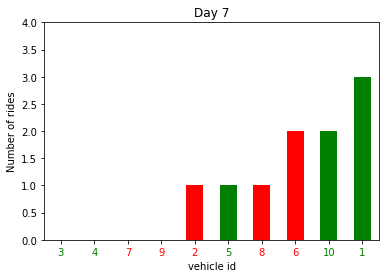

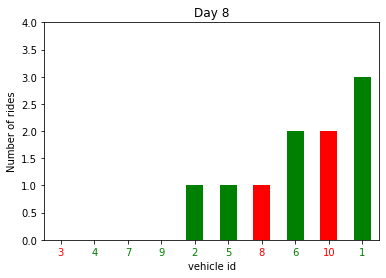

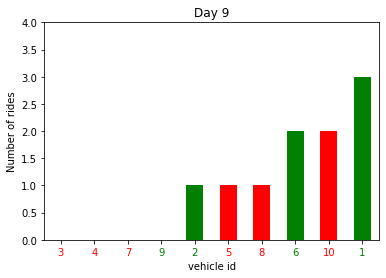

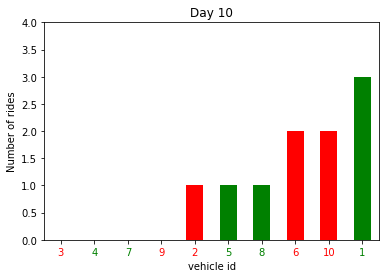

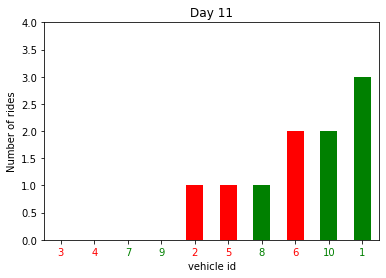

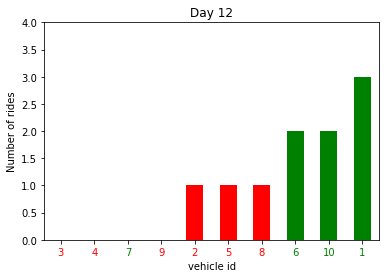

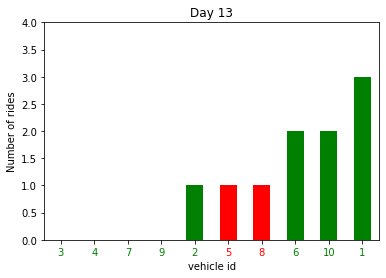

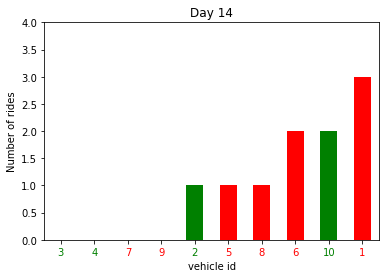

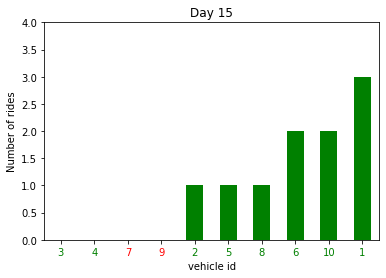

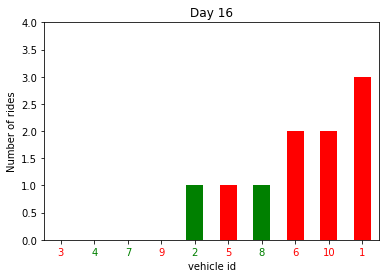

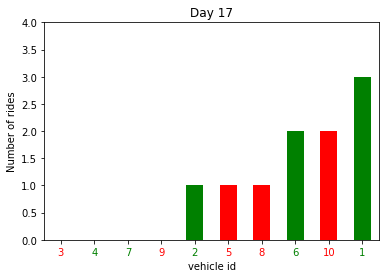

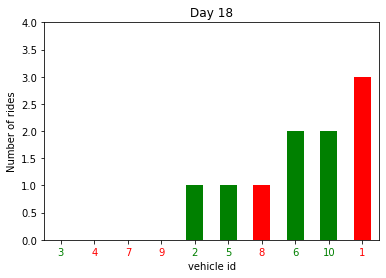

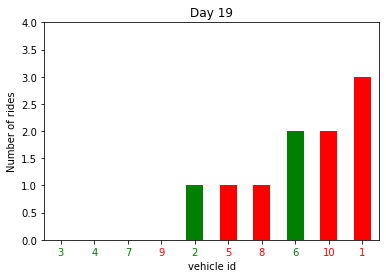

In [41]:
lst = []
for day in range(params.nD):
    lst.extend(sim.res[day].veh_exp['nRIDES'].to_list())
ymax = max(lst) + 1

for day in range(params.nD):
    df = sim.res[day].veh_exp
    df['USE_REPOS'] = use_repos_list[day]
    df = df.sort_values(by=['nRIDES']) 
    colors = ['g' if i else 'r' for i in df['USE_REPOS']]
    
    s = df['nRIDES']
    ax = s.plot.bar(rot=0, title = 'Day ' + str(day), color = colors, ylim = (0,ymax)) 
    ax.set_ylabel('Number of rides')
    ax.set_xlabel('vehicle id')
    [t.set_color(i) for (i,t) in zip(colors, ax.xaxis.get_ticklabels())]
    pyplot.show()

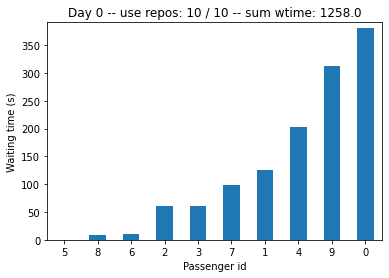

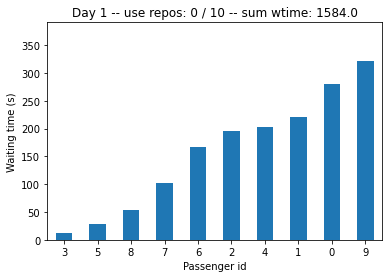

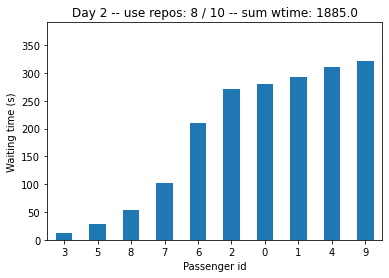

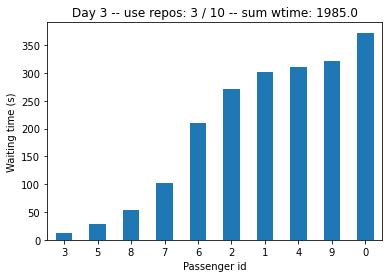

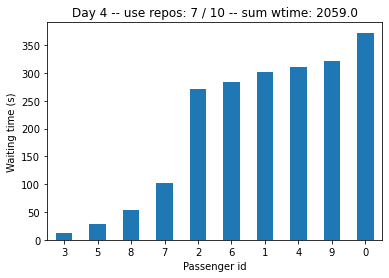

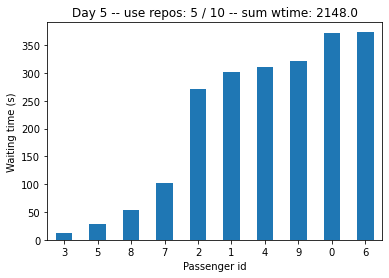

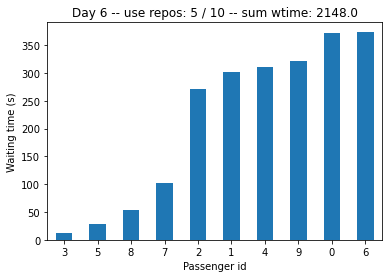

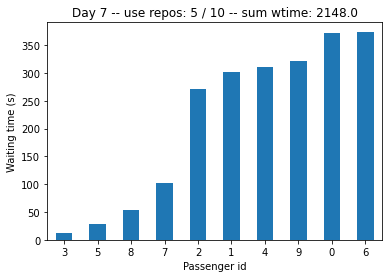

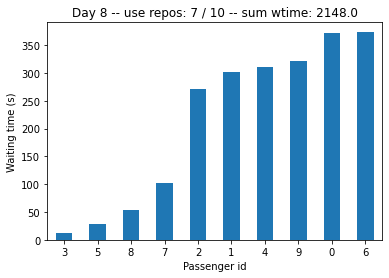

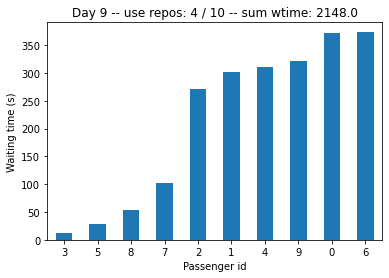

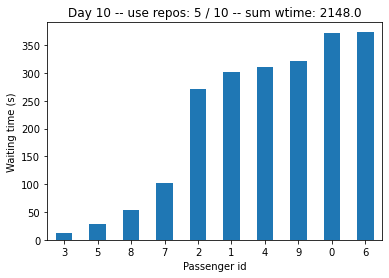

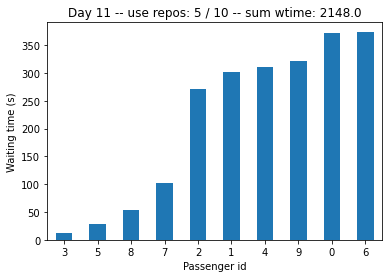

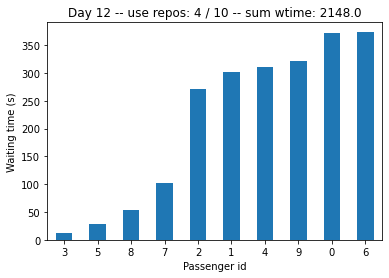

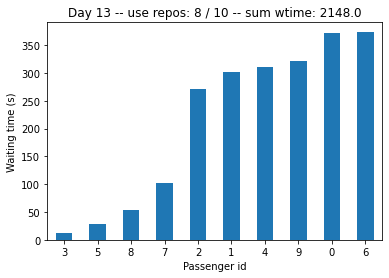

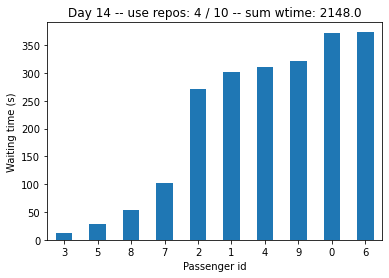

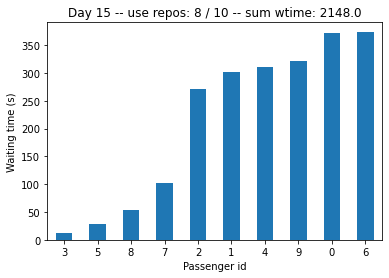

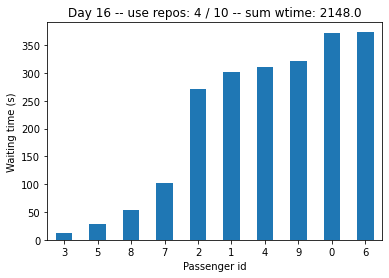

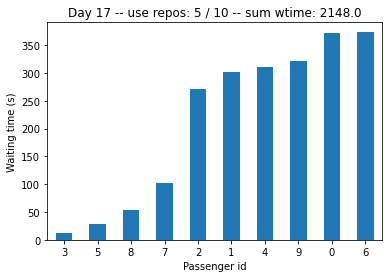

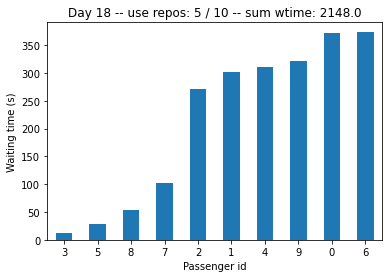

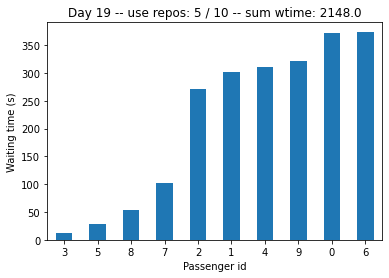

In [42]:
lst = []
for day in range(params.nD):
    lst.extend(sim.res[day].pax_exp['MEETS_DRIVER_AT_PICKUP'].to_list())
ymax = max(lst) + 10

for day in range(params.nD):
    s = sim.res[day].pax_exp['MEETS_DRIVER_AT_PICKUP'].sort_values()
    sum_wtime = sim.res[day].pax_kpi['MEETS_DRIVER_AT_PICKUP']['sum']
    title_str = 'Day ' + str(day) + ' -- use repos: ' + str(sum(use_repos_list[day])) + ' / ' + str(params.nV) + ' -- sum wtime: ' + str(sum_wtime)
    ax = s.plot.bar(rot=0, title = title_str, ylim = (0,ymax)) 
    ax.set_ylabel('Waiting time (s)')
    ax.set_xlabel('Passenger id')
    pyplot.show()

In [131]:
# s1 = sim.res[1].veh_kpi['PROFIT'].rename("PROFIT NO REPOS")
# s2 = sim.res[0].veh_kpi['PROFIT'].rename("PROFIT REPOS")
# df = pd.concat([s1,s2], axis = 1)
# df['DIFF'] = df['PROFIT REPOS'] - df['PROFIT NO REPOS']
# df['DIFF PERC'] = df['DIFF'] / df['PROFIT NO REPOS'] * 100
# df.round(2)

In [132]:
# s1 = sim.res[1].pax_kpi['MEETS_DRIVER_AT_PICKUP'].rename("WTIME NO REPOS")
# s2 = sim.res[0].pax_kpi['MEETS_DRIVER_AT_PICKUP'].rename("WTIME REPOS")
# df = pd.concat([s1,s2], axis = 1)
# df['DIFF'] = df['WTIME REPOS'] - df['WTIME NO REPOS']
# df['DIFF PERC'] = df['DIFF'] / df['WTIME NO REPOS'] * 100
# df.round(1)

In [130]:
# s1 = sim.res[1].veh_exp['PROFIT'].sort_values() # Without repositioning
# s2 = sim.res[0].veh_exp['PROFIT'].sort_values() # With repositioning
# s3 = pd.concat([s1,s2])
# ymin = s3.min() - 1
# ymax = s3.max() + 1

# ax = s1.plot.bar(rot=0, title = 'No repositioning', ylim = (ymin,ymax)) 
# ax.set_ylabel('Profit (EUR)')
# ax.set_xlabel('vehicle id')
# ax.axhline(color='black',lw=1)
# pyplot.show()

# ax = s2.plot.bar(rot=0, title='With repositioning', ylim = (ymin,ymax))
# ax.set_ylabel('Profit (EUR)')
# ax.set_xlabel('vehicle id')
# ax.axhline(color='black',lw=1)
# pyplot.show()

#pyplot.savefig()

In [129]:
# s1 = sim.res[1].veh_exp['nRIDES'].sort_values() # Without repositioning
# s2 = sim.res[0].veh_exp['nRIDES'].sort_values() # With repositioning
# ymax = pd.concat([s1,s2]).max() + 1

# ax = s1.plot.bar(rot=0, title = 'No repositioning', ylim = (0,ymax)) 
# ax.set_ylabel('Number of rides')
# ax.set_xlabel('vehicle id')
# pyplot.show()

# ax = s2.plot.bar(rot=0, title='With repositioning', ylim = (0,ymax))
# ax.set_ylabel('Number of rides')
# ax.set_xlabel('vehicle id')
# pyplot.show()

In [128]:
# s1 = sim.res[1].pax_exp['MEETS_DRIVER_AT_PICKUP'].sort_values() # Without repositioning
# s2 = sim.res[0].pax_exp['MEETS_DRIVER_AT_PICKUP'].sort_values() # With repositioning
# ymax = pd.concat([s1,s2]).max() + 10

# ax = s1.plot.bar(rot=0, title = 'No repositioning', ylim = (0,ymax)) 
# ax.set_ylabel('Waiting time (s)')
# ax.set_xlabel('Passenger id')
# pyplot.show()

# ax = s2.plot.bar(rot=0, title='With repositioning', ylim = (0,ymax))
# ax.set_ylabel('Waiting time (s)')
# ax.set_xlabel('Passenger id')
# pyplot.show()

# Visualization

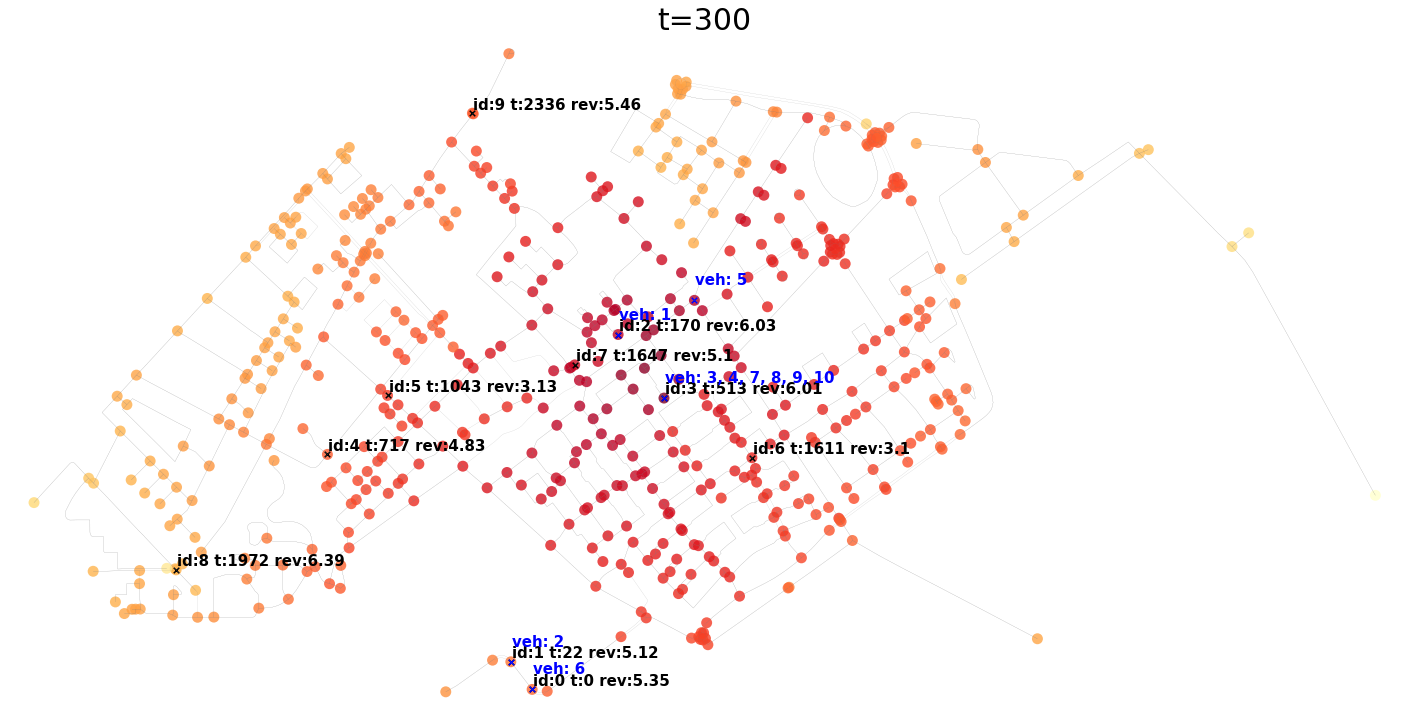

In [158]:
req_ts = inData.requests[['origin','treq_sim']].groupby(['origin'])['treq_sim'].apply(lambda x: ','.join(x.astype(str)))
req_rev = inData.requests[['origin','revenue']].round(2).groupby(['origin'])['revenue'].apply(lambda x: ','.join(x.astype(str)))
req_id = inData.requests[['origin','pax_id']].groupby(['origin'])['pax_id'].apply(lambda x: ','.join(x.astype(str)))
nodes = list(set(inData.requests['origin'].tolist()))
rides = sim.runs[0].rides

time_step = 300
p_values = inData.P.loc[time_step]
if min(p_values) == max(p_values):
    norm_color_lst = p_values.replace(p_values, 0)
else:
    norm_color_lst = (p_values - min(p_values)) / (max(p_values) - min(p_values)) # Normalize and get cmap value for each node
cmap = cm.get_cmap('YlOrRd')
color_vals = cmap(norm_color_lst)

fig, ax = ox.plot_graph(inData.G,fig_height=18, fig_width=25, node_size=120, show=False, edge_linewidth=0.1, edge_color='grey', node_color = color_vals, node_alpha = 0.8)
ax.set_title('t='+str(time_step),fontsize=30)

# Visualize and annotate requests
for node in nodes:
    ax.scatter(inData.G.nodes[node]['x'], inData.G.nodes[node]['y'], s=30, c='black', marker='x')
    ax.annotate('id:' + str(req_id.loc[node]) + ' t:'+ str(req_ts.loc[node]) + ' rev:'+ str(req_rev.loc[node]), (inData.G.nodes[node]['x']*1.00001, inData.G.nodes[node]['y']*1.000002), color='black',fontsize=15, fontweight='bold')

# Visualize and annotate vehicle location at current time step
pos_dict = {}
for v in sim.vehs.keys():
    veh_pos = rides.loc[(rides.veh == v) & (rides.t < time_step)].iloc[-1].pos
    if veh_pos in pos_dict:
        pos_dict[veh_pos] += ', ' + str(v)
    else:
        pos_dict[veh_pos] = str(v)
    
for key, v in pos_dict.items():
    ax.scatter(inData.G.nodes[key]['x'], inData.G.nodes[key]['y'], s=30, c='blue', marker='x')
    ax.annotate('veh: ' + v, (inData.G.nodes[key]['x']*1.00001, inData.G.nodes[key]['y']*1.000008), color='blue',fontsize=15, fontweight='bold')

fig

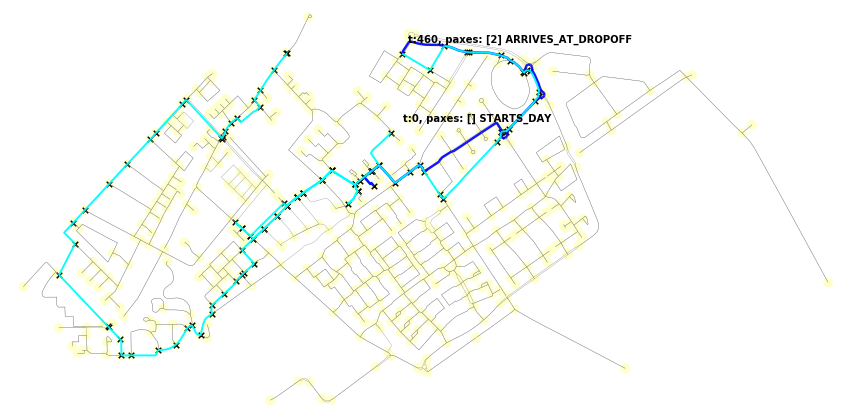

In [157]:
time_step = 3200
p_values = inData.P.loc[time_step]
if min(p_values) == max(p_values):
    norm_color_lst = p_values.replace(p_values, 0)
else:
    norm_color_lst = (p_values - min(p_values)) / (max(p_values) - min(p_values)) # Normalize and get cmap value for each node
cmap = cm.get_cmap('YlOrRd')
color_vals = cmap(norm_color_lst)
rides = sim.runs[0].rides
ride = rides[rides.veh == 1]
plot_veh(inData.G, ride, color_vals)
#print(ride.to_string())

**Old code**

In [155]:
# # Visualize potential values of random node over time
# nodes = random.choices(list(inData.G.nodes), k=2)
# plt = p_vals[nodes].plot(title="node "+str(nodes) + " values", figsize = (14,12), ylim=(0,p_vals[nodes].values.max()+1));
# # p_vals[]

In [1]:
# Old potential value generation after sim = Simulator() (now before, without using sim.t1 etc.)

# inData.requests['treq_sim'] = (inData.requests['treq'] - sim.t0).dt.total_seconds().astype(int) # Request time to simulation timesteps (seconds)
# df_list = []
# for i, req in inData.requests.iterrows():
#     df = pd.DataFrame(index = range(sim.t1+1), columns = inData.G.nodes, dtype = 'float').rename_axis(index = 'time', columns = 'nodes')  # Create df with nodes as columns and all timesteps as index
#     df.loc[req['treq_sim']] = sim.skims.decay.loc[req['origin']] + req['revenue']  # Create potential values of request with spatial decay and set it on the index of request time
#     df.loc[0] = df.loc[req['treq_sim']] - req['treq_sim'] * params.potential.time_decay # Calculate the temporal decay at time t0 for each node and set row
#     df.loc[0:req['treq_sim']] = df.loc[0:req['treq_sim']].interpolate() # Linear interpolation between t0 and t_req
#     df.loc[req['treq_sim']:min(req['treq_sim'] + params.potential.available, sim.t1),:] = df.loc[req['treq_sim']].values # Keep potential values the same for some time after t_req
#     df_list.append(df)
# p_vals = pd.concat(df_list, keys = range(len(inData.requests)), names = ['requests']) # Spatio-temporal potential values dataframe for each seperate request concatenated into one
# p_vals = p_vals.groupby(by = 'time').max() # Find max value by comparing each node and time step for each request 
# p_vals = p_vals.fillna(-10000)
# inData.P = p_vals
#inData.P
#inData.requests

# Check link travel times

# vals = []
# for node in inData.G.nodes:
#     nbs = inData.G.neighbors(node)
#     vals.extend(inData.skim.loc[node,nbs].values)
# vals = [val / (50 / 3.6) for val in vals]
# nlargest(30,vals)
# np.mean(vals)

# Draw single nodes

# draw_nodes = [45017813,45017764]
# print(inData.G.nodes[45017813])
# neighbor = [x for x in inData.G.neighbors(45017813)]
# print(neighbor)
# fig, ax = ox.plot_graph(inData.G, fig_height=15, fig_width=25, node_size=10, show=False, edge_linewidth=0.1, edge_color='grey')
# for node in draw_nodes:
#     ax.annotate(node, (inData.G.nodes[node]['x'], inData.G.nodes[node]['y']))
# fig

# sim.requests
# inData.requests

# Plot vehicles
# i=6
# print(df[df.veh == i])
# plot_veh(inData.G, df[df.veh == i])

# Logsum
# math.log(math.exp(0.8) + math.exp(0.2) + math.exp(0.5))
# math.log(math.exp(1))

# Select rows of which a specific column has a specific value
# sim.runs[0].trips.loc[(df2['event'] == 'REQUESTS_RIDE') | (df2['event'] == 'RECEIVES_OFFER')]

# list(inData.G.nodes.data('exp_rev'))
# nx.get_node_attributes(inData.G, 'exp_rev')

        
# repos = self.f_driver_repos(veh=self)  # reposition yourself
# if repos.flag:  # if reposition
#     self.update(event=driverEvent.STARTS_REPOSITIONING)
#     yield self.sim.timeout(repos.time, variability=self.sim.vars.ride)
#     self.update(event=driverEvent.REPOSITIONED, pos=repos.pos)

# self.platform.appendVeh(self.id)  # appended for the queue
# yield self.requested | self.sim.timeout(self.till_end())  # wait until requested or shift end

# Get run results sim.res[run_id]. Keys are 'pax_exp', 'pax_kpi', 'veh_exp', 'veh_kpi'

#[status.name for status in driverEvent]

# Compare ride/trip data with vehicle/passenger results output
#print(sim.res[0].veh_exp.iloc[0])
#ride = rides[rides.veh == 1]
#print(ride)

#print(sim.res[0].pax_exp.iloc[0])
#trip = trips[trips.pax == 0]
#print(trip)

# Add expected revenue to all nodes as attributes
# df_exp_rev = pd.DataFrame(index = list(inData.G.nodes)) # Create empty df with nodes as index
# for ind, req in inData.requests.iterrows():
#     req['treq'] 
#     req_decay = sim.skims.decay.loc[req['origin']] + req['revenue'] # Calculate decayed values for each request for all nodes
#     #req_decay[req_decay < 0] = 0 # Set negative values to zero
#     df_exp_rev[req['origin']] = req_decay # Add decay values for each request as column to revenue df
# df_exp_rev['value'] = df_exp_rev.apply(lambda node: max(node), axis = 1) # Find maximum value for each node
# nx.set_node_attributes(inData.G, df_exp_rev['value'].to_dict(), 'exp_rev')

# cmap = cm.get_cmap('YlOrRd')
# exp_rev_lst = [inData.G.nodes[n]['exp_rev'] for n in inData.G.nodes] 
# norm_color_lst = [(n-min(exp_rev_lst))/(max(exp_rev_lst)-min(exp_rev_lst)) for n in exp_rev_lst] # Normalize and get cmap value for each node
# color_vals = cmap(norm_color_lst)

# rides = sim.runs[0].rides
# ride = rides[rides.veh == 1]
# plot_veh(inData.G, ride, color_vals)

#     # repos.flag = False causes break out of reposition loop triggers driverEvent.REPOSITIONED
#     if p_val_t[new_pos] > p_val_t[cur_pos]:
#         repos.pos = new_pos # Reposition to node with highest exp_rev attribute value. Pick first encounter when similar values
#         repos.time = veh.sim.skims.ride[cur_pos][new_pos] # Time from current to new node using time skim matrix
#         print(f"Vehicle {veh.id} at t:{veh.sim.env.now} from {cur_pos} (value: {round(p_val_t[cur_pos],2)}) to {new_pos} (value: {round(p_val_t[new_pos],2)})")  
#     else:
#         repos.flag = False
#         repos.pos = cur_pos
#     return repos
    

In [109]:
# # Ordered distribution with and without repositioning of vehicle profit, number of rides and passenger waiting time 
# s1 = sim.res[1].veh_exp['PROFIT'].rename("Without repositioning").sort_values().reset_index(drop=True)
# s2 = sim.res[0].veh_exp['PROFIT'].rename("With repositioning").sort_values().reset_index(drop=True)
# df = pd.concat([s1,s2], axis = 1)
# #plt = df.plot.bar(subplots=True, title = 'Profit per vehicle distribution', figsize=(6.7,4), layout=(1,2), legend=False, ylim = (df.values.min()-1, df.values.max() + 1))
# plt = df.plot.bar(subplots=True, figsize=(6,3), layout=(1,2), legend=False, ylim = (df.values.min()-1, df.values.max() + 1))
# plt[0][0].set_ylabel("Profit (EUR)", fontsize=10)
# plt[0][0].set_xlabel("Individual drivers", fontsize=10)
# plt[0][1].set_xlabel("Individual drivers", fontsize=10)
# plt[0][0].set_xticklabels([])
# #plt[0][0].set_xticks([])
# plt[0][0].axhline(color='black',lw=1,ls='--')
# plt[0][1].axhline(color='black',lw=1,ls='--')
# pyplot.savefig('profit2.png', dpi=300)

# s1 = sim.res[1].veh_exp['nRIDES'].rename("Without repositioning").sort_values().reset_index(drop=True)
# s2 = sim.res[0].veh_exp['nRIDES'].rename("With repositioning").sort_values().reset_index(drop=True)
# df = pd.concat([s1,s2], axis = 1)
# #plt = df.plot.bar(subplots=True, title = 'Rides per vehicle distribution', figsize=(6.7,4), layout=(1,2), legend=False, ylim = (0, df.values.max() + 1))
# plt = df.plot.bar(subplots=True, figsize=(6,3), layout=(1,2), legend=False, ylim = (0, df.values.max() + 1))
# plt[0][0].set_ylabel("Number of rides", fontsize=10)
# plt[0][0].set_xlabel("Individual drivers", fontsize=10)
# plt[0][1].set_xlabel("Individual drivers", fontsize=10)
# plt[0][0].set_xticklabels([])
# #plt[0][0].set_xticks([])
# pyplot.savefig('rides2.png',dpi=300)

# s1 = sim.res[1].pax_exp['MEETS_DRIVER_AT_PICKUP'].rename("Without repositioning").fillna(0).sort_values().reset_index(drop=True)
# s2 = sim.res[0].pax_exp['MEETS_DRIVER_AT_PICKUP'].rename("With repositioning").fillna(0).sort_values().reset_index(drop=True)
# df = pd.concat([s1,s2], axis = 1)
# #plt = df.plot.bar(subplots=True, title = 'Waiting time per passenger distribution', figsize=(6.7,4),layout=(1,2), legend=False, ylim = (0, df.values.max() + 10))
# plt = df.plot.bar(subplots=True, figsize=(8,3),layout=(1,2), legend=False, ylim = (0, df.values.max() + 10))
# plt[0][0].set_ylabel("Waiting time (s)", fontsize=10)
# plt[0][0].set_xlabel("Individual passengers", fontsize=10)
# plt[0][1].set_xlabel("Individual passengers", fontsize=10)
# plt[0][0].set_xticklabels([]);
# #plt[0][0].set_xticks([])
# pyplot.savefig('wait_time2.png',dpi=300)